In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import Perceptron
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import accuracy_score
from imblearn.over_sampling import SMOTE
from scipy import stats
from sklearn.neural_network import MLPClassifier
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
np.random.seed(42)

import warnings
warnings.filterwarnings("ignore", category=FutureWarning, module="numpy")

In [ ]:
def handle_missing_values(data):
    missing_values_count = data.isna().sum().sum()
    num_cols = data.select_dtypes(include=['number']).columns
    median_imputer = SimpleImputer(strategy='median')
    data[num_cols] = median_imputer.fit_transform(data[num_cols])
    cat_cols = data.select_dtypes(include=['object']).columns
    mode_imputer = SimpleImputer(strategy='most_frequent')
    data[cat_cols] = mode_imputer.fit_transform(data[cat_cols])
    handled_missing_values_count = missing_values_count - data.isna().sum().sum()
    return data, handled_missing_values_count

def handle_outliers(data):
    num_cols = data.select_dtypes(include=['number']).columns
    z_scores = np.abs(stats.zscore(data[num_cols]))
    outlier_mask = (z_scores > 4)
    outliers_count = np.sum(outlier_mask)
    data[num_cols] = data[num_cols].mask(outlier_mask, np.nan)  # Mask outliers with NaN
    data, _ = handle_missing_values(data)
    return data, outliers_count

def add_temporal_features(data):
    data['Date'] = pd.to_datetime(data['Date'])
    data['Day_of_Week'] = data['Date'].dt.dayofweek
    data['Month'] = data['Date'].dt.month

    # Adding meteorological season feature
    def get_meteorological_season(month):
        if month in [12, 1, 2]:
            return 'Winter'
        elif month in [3, 4, 5]:
            return 'Spring'
        elif month in [6, 7, 8]:
            return 'Summer'
        elif month in [9, 10, 11]:
            return 'Autumn'

    data['Meteorological_Season'] = data['Month'].apply(get_meteorological_season)
    data = data.drop(columns=['Date'])

    return data

def common_preprocess(data, is_new_data=False, encoders=None):
    data, missing_values_count = handle_missing_values(data)
    data, outliers_count = handle_outliers(data)
    data = add_temporal_features(data)

    if not is_new_data:
        # Log total missing values and outliers handled
        print(f"Total missing values handled: {missing_values_count}")
        print("Total outliers handled:")
        for col, count in outliers_count.items():
            if count > 0:
                print(f"\t {col}: {count}")

        def encode_columns(data, columns):
            encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
            encoded_data = encoder.fit_transform(data[columns])
            encoded_df = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out(columns))
            return encoded_df, encoder

        encoded_internet_issues_df, internet_issues_encoder = encode_columns(data, ['Internet Issues at Home'])
        encoded_radiologist_df, radiologist_encoder = encode_columns(data, ['Radiologist ID'])
        encoded_trainee_df, trainee_encoder = encode_columns(data, ['Trainee Assigned'])
        encoded_supervised_df, supervised_encoder = encode_columns(data, ['Supervised Session'])
        encoded_cold_df, cold_encoder = encode_columns(data, ['Cold Session'])
        encoded_admin_df, admin_encoder = encode_columns(data, ['Admin Work'])
        encoded_season_df, season_encoder = encode_columns(data, ['Meteorological_Season'])

    else:
        internet_issues_encoder, radiologist_encoder, trainee_encoder, supervised_encoder, cold_encoder, admin_encoder, season_encoder = encoders

        internet_issues_encoded = internet_issues_encoder.transform(data[['Internet Issues at Home']])
        encoded_internet_issues_df = pd.DataFrame(internet_issues_encoded, columns=internet_issues_encoder.get_feature_names_out(['Internet Issues at Home']))
        radiologist_encoded = radiologist_encoder.transform(data[['Radiologist ID']])
        encoded_radiologist_df = pd.DataFrame(radiologist_encoded, columns=radiologist_encoder.get_feature_names_out(['Radiologist ID']))
        trainee_encoded = trainee_encoder.transform(data[['Trainee Assigned']])
        encoded_trainee_df = pd.DataFrame(trainee_encoded, columns=trainee_encoder.get_feature_names_out(['Trainee Assigned']))
        supervised_encoded = supervised_encoder.transform(data[['Supervised Session']])
        encoded_supervised_df = pd.DataFrame(supervised_encoded, columns=supervised_encoder.get_feature_names_out(['Supervised Session']))
        cold_encoded = cold_encoder.transform(data[['Cold Session']])
        encoded_cold_df = pd.DataFrame(cold_encoded, columns=cold_encoder.get_feature_names_out(['Cold Session']))
        admin_encoded = admin_encoder.transform(data[['Admin Work']])
        encoded_admin_df = pd.DataFrame(admin_encoded, columns=admin_encoder.get_feature_names_out(['Admin Work']))
        season_encoded = season_encoder.transform(data[['Meteorological_Season']])
        encoded_season_df = pd.DataFrame(season_encoded, columns=season_encoder.get_feature_names_out(['Meteorological_Season']))

    data = pd.concat([
        data, encoded_internet_issues_df, encoded_radiologist_df, encoded_trainee_df,
        encoded_supervised_df, encoded_cold_df, encoded_admin_df, encoded_season_df
    ], axis=1)
    data = data.drop(columns=[
        'Radiologist ID', 'Internet Issues at Home', 'Trainee Assigned',
        'Supervised Session', 'Cold Session', 'Admin Work', 'Meteorological_Season'
    ])

    data['Rainfall_travel'] = data['Rainfall (mm)'] * data['Travel Cost (£)']
    data['Avg_temp_travel'] = data['Avg Temp (°C)'] * data['Travel Cost (£)']

    for radiologist_col in encoded_radiologist_df.columns:
        for feature in ['Avg Temp (°C)', 'Rainfall (mm)', 'Travel Cost (£)', 'Day_of_Week', 'Month'] + list(encoded_internet_issues_df.columns):
            data[f'{radiologist_col}_{feature}_Interaction'] = encoded_radiologist_df[radiologist_col] * data[feature]

    combined_interaction = (encoded_supervised_df.values * encoded_cold_df.values * encoded_admin_df.values).sum(axis=1)
    data['Supervised_Cold_Admin_Interaction'] = combined_interaction

    poly = PolynomialFeatures(degree=2, include_bias=False)
    poly_features = poly.fit_transform(data[['Avg Temp (°C)', 'Rainfall (mm)', 'Travel Cost (£)']])
    poly_df = pd.DataFrame(poly_features, columns=poly.get_feature_names_out(['Avg Temp (°C)', 'Rainfall (mm)', 'Travel Cost (£)']))
    data = pd.concat([data, poly_df], axis=1)

    return data, (
        internet_issues_encoder, radiologist_encoder, trainee_encoder,
        supervised_encoder, cold_encoder, admin_encoder, season_encoder
    )

def encode_targets(data):
    # Encode categorical target variables as numeric values using LabelEncoder
    encoders = {}
    for col in ['Morning Shift Work Location', 'Afternoon Shift Work Location']:
        le = LabelEncoder()
        data[col] = le.fit_transform(data[col])
        encoders[col] = le
    return data, encoders

def apply_smote(X, y, target_encoders):
    smote = SMOTE(random_state=42)
    X_resampled = X.copy()
    y_resampled = pd.DataFrame(index=y.index)

    # Prepare lists to collect class distribution data
    original_dist_data = []
    resampled_dist_data = []

    for column in y.columns:
        print(f"\nApplying SMOTE for target column: {column}")

        # Collect original class distribution
        original_dist = y[column].value_counts().reset_index()
        original_dist.columns = ['Class', 'Count']
        original_dist['Target'] = column
        original_dist['Class'] = target_encoders[column].inverse_transform(original_dist['Class'])
        original_dist_data.append(original_dist)

        print("Original Class Distribution:")
        print(original_dist)

        # Apply SMOTE to each target column
        X_resampled_col, y_resampled_col = smote.fit_resample(X, y[column])
        y_resampled[column] = y_resampled_col

        # Collect resampled class distribution
        resampled_dist = pd.Series(y_resampled_col).value_counts().reset_index()
        resampled_dist.columns = ['Class', 'Count']
        resampled_dist['Target'] = column
        resampled_dist['Class'] = target_encoders[column].inverse_transform(resampled_dist['Class'])
        resampled_dist_data.append(resampled_dist)

        print("Resampled Class Distribution:")
        print(resampled_dist)

    # Combine distributions into DataFrames
    original_dist_df = pd.concat(original_dist_data).reset_index(drop=True)
    resampled_dist_df = pd.concat(resampled_dist_data).reset_index(drop=True)

    # Plot original class distributions
    plt.figure(figsize=(12, 4))
    sns.barplot(data=original_dist_df, x='Class', y='Count', hue='Target', palette='coolwarm')
    plt.title('Original Class Distributions Before SMOTE')
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.legend(title='Target Variable')
    plt.show()

    # Plot resampled class distributions
    plt.figure(figsize=(12, 4))
    sns.barplot(data=resampled_dist_df, x='Class', y='Count', hue='Target', palette='coolwarm', legend=False)
    plt.title('Class Distributions After SMOTE')
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.show()

    return X_resampled, y_resampled


def evaluate_model(model, X, y):
    # Predict target values using the model
    y_pred = model.predict(X)

    # Calculate accuracy for each target variable
    accuracies = [accuracy_score(y.iloc[:, i], y_pred[:, i]) for i in range(y.shape[1])]

    return y_pred, accuracies


Total missing values handled: 0
Total outliers handled:
	 Rainfall (mm): 22
	 Travel Cost (£): 14

Applying SMOTE for target column: Morning Shift Work Location
Original Class Distribution:
    Class  Count                       Target
0  office   1676  Morning Shift Work Location
1    home    612  Morning Shift Work Location
Resampled Class Distribution:
    Class  Count                       Target
0  office   1676  Morning Shift Work Location
1    home   1676  Morning Shift Work Location

Applying SMOTE for target column: Afternoon Shift Work Location
Original Class Distribution:
    Class  Count                         Target
0  office   1537  Afternoon Shift Work Location
1    home    751  Afternoon Shift Work Location
Resampled Class Distribution:
    Class  Count                         Target
0  office   1537  Afternoon Shift Work Location
1    home   1537  Afternoon Shift Work Location


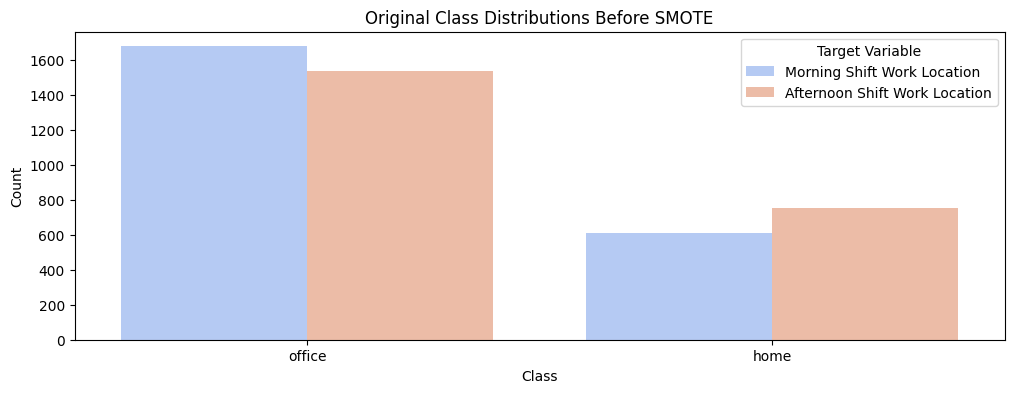

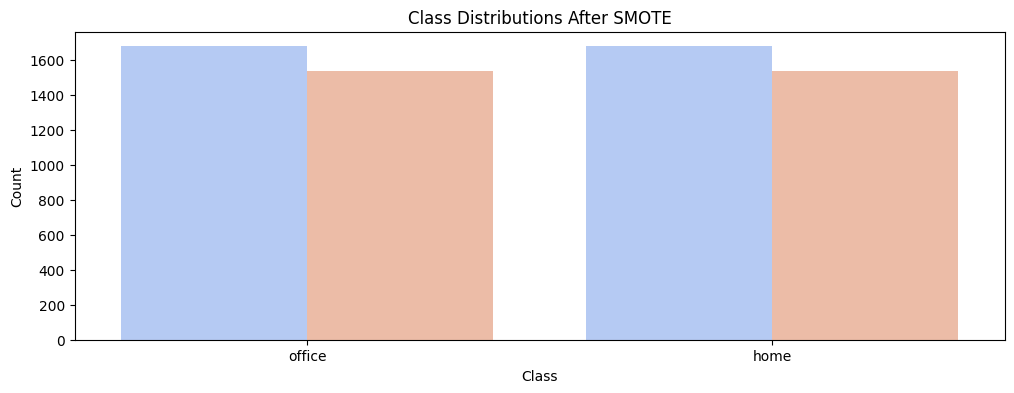

Perceptron Prediction Accuracies:
Train:
	Morning Shift Work Location: 0.7548076923076923
	Afternoon Shift Work Location: 0.7810314685314685
Test:
	Morning Shift Work Location: 0.8426573426573427
	Afternoon Shift Work Location: 0.8601398601398601

MLP Classifier Prediction Accuracies:
Train:
	Morning Shift Work Location: 0.8479020979020979
	Afternoon Shift Work Location: 0.8684440559440559
Test:
	Morning Shift Work Location: 0.8688811188811189
	Afternoon Shift Work Location: 0.8583916083916084

Perceptron Classification Reports:
Train:

Classification Report for Morning Shift Work Location (Train):
              precision    recall  f1-score   support

           0       0.54      0.53      0.54       612
           1       0.83      0.84      0.83      1676

    accuracy                           0.75      2288
   macro avg       0.69      0.68      0.69      2288
weighted avg       0.75      0.75      0.75      2288


Classification Report for Afternoon Shift Work Location (Train):
 

In [ ]:
# Load dataset
data = pd.read_csv('simulated_data.csv')

# Preprocess the dataset
processed_data, encoders = common_preprocess(data)
processed_data, target_encoders = encode_targets(processed_data)

# Separate features and target variables
X = processed_data.drop(columns=['Morning Shift Work Location', 'Afternoon Shift Work Location'])
y = processed_data[['Morning Shift Work Location', 'Afternoon Shift Work Location']]

# Sort the data by index to maintain sequential split
data_sorted = pd.concat([X, y], axis=1).sort_index()

# Define the split index
split_index = int(len(data_sorted) * 0.8)

# Split data into training and test sets
X_train = data_sorted.iloc[:split_index].drop(columns=['Morning Shift Work Location', 'Afternoon Shift Work Location'])
X_test = data_sorted.iloc[split_index:].drop(columns=['Morning Shift Work Location', 'Afternoon Shift Work Location'])
y_train = data_sorted.iloc[:split_index][['Morning Shift Work Location', 'Afternoon Shift Work Location']]
y_test = data_sorted.iloc[split_index:][['Morning Shift Work Location', 'Afternoon Shift Work Location']]

# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Apply SMOTE to the scaled data
X_train_resampled, y_train_resampled = apply_smote(X_train_scaled, y_train, target_encoders)

# Create and train the Perceptron
perceptron_model = Perceptron(
    alpha=0.1,
    fit_intercept=True,
    max_iter=500,
    random_state=42
)
multioutput_perceptron_model = MultiOutputClassifier(perceptron_model)
multioutput_perceptron_model.fit(X_train_resampled, y_train_resampled)

# Create and train the MLPClassifier
mlp_model = MLPClassifier(
    hidden_layer_sizes=(64, 32),
    activation='relu',
    solver='adam',
    alpha=1,
    batch_size='auto',
    learning_rate='adaptive',
    learning_rate_init=0.01,
    max_iter=500,
    random_state=42
)
multioutput_mlp_model = MultiOutputClassifier(mlp_model)
multioutput_mlp_model.fit(X_train_resampled, y_train_resampled)

# Evaluate models
y_pred_perceptron_train, train_accuracies_perceptron = evaluate_model(multioutput_perceptron_model, X_train_scaled, y_train_resampled)
y_pred_perceptron_test, test_accuracies_perceptron = evaluate_model(multioutput_perceptron_model, X_test_scaled, y_test)

y_pred_mlp_train, train_accuracies_mlp = evaluate_model(multioutput_mlp_model, X_train_scaled, y_train_resampled)
y_pred_mlp_test, test_accuracies_mlp = evaluate_model(multioutput_mlp_model, X_test_scaled, y_test)

print("Perceptron Prediction Accuracies:")
print("Train:")
print("\tMorning Shift Work Location:", train_accuracies_perceptron[0])
print("\tAfternoon Shift Work Location:", train_accuracies_perceptron[1])
print("Test:")
print("\tMorning Shift Work Location:", test_accuracies_perceptron[0])
print("\tAfternoon Shift Work Location:", test_accuracies_perceptron[1])

print("\nMLP Classifier Prediction Accuracies:")
print("Train:")
print("\tMorning Shift Work Location:", train_accuracies_mlp[0])
print("\tAfternoon Shift Work Location:", train_accuracies_mlp[1])
print("Test:")
print("\tMorning Shift Work Location:", test_accuracies_mlp[0])
print("\tAfternoon Shift Work Location:", test_accuracies_mlp[1])

# Print classification reports for Perceptron
print("\nPerceptron Classification Reports:")
print("Train:")
for i, target in enumerate(y_train.columns):
    print(f"\nClassification Report for {target} (Train):")
    print(classification_report(y_train[target], y_pred_perceptron_train[:, i]))

print("Test:")
for i, target in enumerate(y_test.columns):
    print(f"\nClassification Report for {target} (Test):")
    print(classification_report(y_test[target], y_pred_perceptron_test[:, i]))

# Print classification reports for MLPClassifier
print("\nMLP Classifier Classification Reports:")
print("Train:")
for i, target in enumerate(y_train.columns):
    print(f"\nClassification Report for {target} (Train):")
    print(classification_report(y_train[target], y_pred_mlp_train[:, i]))

print("Test:")
for i, target in enumerate(y_test.columns):
    print(f"\nClassification Report for {target} (Test):")
    print(classification_report(y_test[target], y_pred_mlp_test[:, i]))


In [ ]:
# Define the new data
new_data = pd.DataFrame({
    'Radiologist ID': ['R1'],
    'Date': ['2024/08/05'],
    'Avg Temp (°C)': [12.417],
    'Rainfall (mm)': [20],
    'Travel Cost (£)': [5],
    'Internet Issues at Home': ['No'],
    'Trainee Assigned': ['No'],
    'Supervised Session': ['No'],
    'Cold Session': ['No'],
    'Admin Work': ['No']
})

# Preprocess the new data
new_data_processed, _ = common_preprocess(new_data, is_new_data=True, encoders=encoders)

# Separate features from the processed new data
X_new = new_data_processed.drop(columns=['Morning Shift Work Location', 'Afternoon Shift Work Location'], errors='ignore')

# Scale the new data
X_new_scaled = scaler.transform(X_new)

# Make predictions using the MLP Classifier model
y_pred_mlp = multioutput_mlp_model.predict(X_new_scaled)

# Decode the predictions using the stored LabelEncoders
morning_shift_pred = target_encoders['Morning Shift Work Location'].inverse_transform([y_pred_mlp[0][0]])
afternoon_shift_pred = target_encoders['Afternoon Shift Work Location'].inverse_transform([y_pred_mlp[0][1]])

# Print the decoded predictions
print("MLP Classifier Predictions:")
print("\tMorning Shift Work Location:", morning_shift_pred[0])
print("\tAfternoon Shift Work Location:", afternoon_shift_pred[0])

MLP Classifier Predictions:
	Morning Shift Work Location: office
	Afternoon Shift Work Location: office


## Experiment 1: Comparison of Baseline Models for Multi-Output Classification

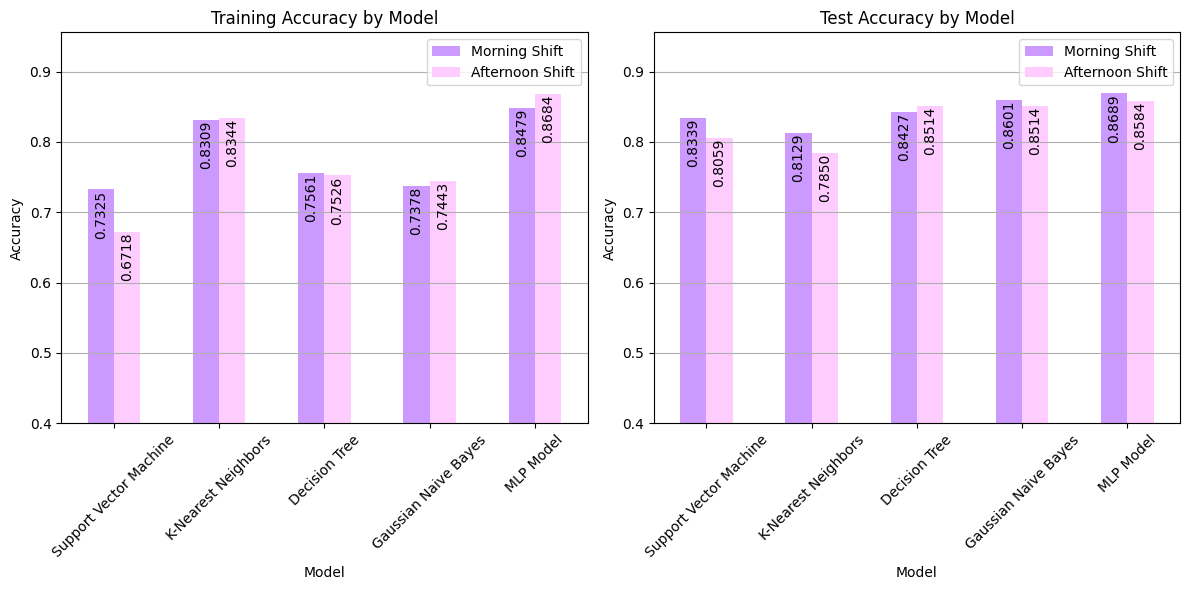

In [ ]:
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

# Define baseline models for binary classification
models = {
    "Support Vector Machine": SVC(C=0.01,probability=True, random_state=42),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Decision Tree" : DecisionTreeClassifier(max_depth=5, random_state=42),
    "Gaussian Naive Bayes" : GaussianNB()
}

results = {}

# Train and evaluate each baseline model
for model_name, model in models.items():
    # MultiOutputClassifier to handle multi-output problems
    multioutput_model = MultiOutputClassifier(model)

    # Train the model
    multioutput_model.fit(X_train_scaled, y_train_resampled)

    # Evaluate on training and test sets
    y_pred_train, train_accuracies = evaluate_model(multioutput_model, X_train_scaled, y_train_resampled)
    y_pred_test, test_accuracies = evaluate_model(multioutput_model, X_test_scaled, y_test)

    # Store results
    results[model_name] = {
        'Train Morning Shift': train_accuracies[0],
        'Train Afternoon Shift': train_accuracies[1],
        'Test Morning Shift': test_accuracies[0],
        'Test Afternoon Shift': test_accuracies[1]
    }


# Add the MLP model results to the results dictionary
results['MLP Model'] = {
    'Train Morning Shift': train_accuracies_mlp[0],
    'Train Afternoon Shift': train_accuracies_mlp[1],
    'Test Morning Shift': test_accuracies_mlp[0],
    'Test Afternoon Shift': test_accuracies_mlp[1]
}

# Convert results to DataFrame
results_df = pd.DataFrame(results).T

# Plot results
plt.figure(figsize=(12, 6))

y_start = 0.4
y_limits = (y_start, max(results_df.max()) * 1.1)

# Training accuracies
plt.subplot(1, 2, 1)
ax = results_df[['Train Morning Shift', 'Train Afternoon Shift']].plot(kind='bar', ax=plt.gca(), rot=45, color=['#cc99ff', '#ffccff'])
plt.title('Training Accuracy by Model')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.ylim(y_limits)
plt.legend(['Morning Shift', 'Afternoon Shift'])
plt.grid(axis='y')

# Add value labels at the bottom of bars for training accuracies
for container in ax.containers:
    for bar in container:
        height = bar.get_height()
        ax.text(
            bar.get_x() + bar.get_width() / 2.0,
            height - 0.07,
            f'{height:.4f}',
            ha='center',
            va='bottom',
            fontsize=10,
            rotation=90
        )

# Test accuracies
plt.subplot(1, 2, 2)
ax = results_df[['Test Morning Shift', 'Test Afternoon Shift']].plot(kind='bar', ax=plt.gca(), rot=45,  color=['#cc99ff', '#ffccff'])
plt.title('Test Accuracy by Model')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.ylim(y_limits)
plt.legend(['Morning Shift', 'Afternoon Shift'])
plt.grid(axis='y')

# Add value labels at the bottom of bars for test accuracies
for container in ax.containers:
    for bar in container:
        height = bar.get_height()
        ax.text(
            bar.get_x() + bar.get_width() / 2.0,
            height - 0.07,
            f'{height:.4f}',
            ha='center',
            va='bottom',
            fontsize=10,
            rotation=90
        )

plt.tight_layout()
plt.show()

## Experiment 2: Results of PCA on Multi-Layer Perceptron Model
Performance

In [ ]:
# Define the original number of dimensions
original_dim = X_train_resampled.shape[1]

print("Input feature count before applying PCA:", original_dim)

Input feature count before applying PCA: 119


Best number of principal components: 87
Best combined score: 0.8087


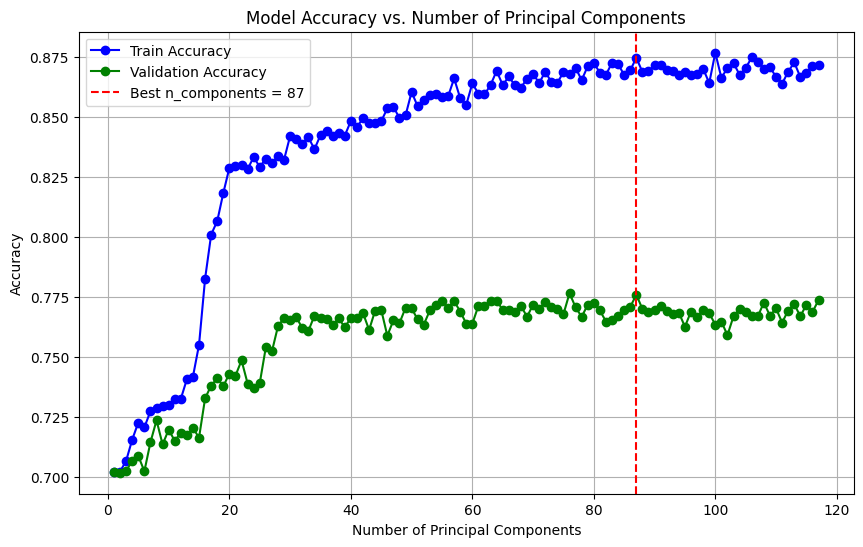

In [ ]:
from sklearn.model_selection import KFold

# Define the range of n_components to evaluate
n_components_range = range(1, original_dim - 1)

# Variables to store results
best_n_components = None
best_combined_score = 0
train_accuracies_list = []
val_accuracies_list = []

# Set up KFold cross-validation without shuffling
kf = KFold(n_splits=5, shuffle=False)

# Loop over each number of components
for n_components in n_components_range:
    fold_train_accuracies = []
    fold_val_accuracies = []

    # Apply KFold cross-validation
    for train_index, val_index in kf.split(X_train_resampled):
        X_train_sub, X_val = X_train_resampled[train_index], X_train_resampled[val_index]
        y_train_sub, y_val = y_train_resampled.iloc[train_index], y_train_resampled.iloc[val_index]

        # Apply PCA with the current number of components on training data
        pca = PCA(n_components=n_components, random_state=42)
        X_train_pca = pca.fit_transform(X_train_sub)
        X_val_pca = pca.transform(X_val)

        # Initialize a new model for each iteration
        mlp_model = MLPClassifier(
            hidden_layer_sizes=(64, 32),
            activation='relu',
            solver='adam',
            alpha=1,
            batch_size='auto',
            learning_rate='adaptive',
            learning_rate_init=0.01,
            max_iter=500,
            random_state=42
        )
        multioutput_mlp_model_pca = MultiOutputClassifier(mlp_model)

        # Train the MLPClassifier with PCA-reduced data
        multioutput_mlp_model_pca.fit(X_train_pca, y_train_sub)

        # Evaluate the model on training data
        y_pred_mlp_train_pca, train_accuracies_mlp_pca = evaluate_model(multioutput_mlp_model_pca, X_train_pca, y_train_sub)

        # Evaluate the model on validation data
        y_pred_mlp_val_pca, val_accuracies_mlp_pca = evaluate_model(multioutput_mlp_model_pca, X_val_pca, y_val)

        # Store fold accuracies
        fold_train_accuracies.append(np.mean(train_accuracies_mlp_pca))
        fold_val_accuracies.append(np.mean(val_accuracies_mlp_pca))

    # Calculate the average accuracy across all folds for current number of components
    mean_train_accuracy = np.mean(fold_train_accuracies)
    mean_val_accuracy = np.mean(fold_val_accuracies)

    # Calculate a combined score (2/3 validation, 1/3 training)
    combined_score = (2/3) * mean_val_accuracy + (1/3) * mean_train_accuracy

    # Store results for this number of components
    train_accuracies_list.append(mean_train_accuracy)
    val_accuracies_list.append(mean_val_accuracy)

    # Check if this is the best number of components so far
    if combined_score > best_combined_score:
        best_combined_score = combined_score
        best_n_components = n_components

# Print the best number of components and corresponding combined score
print(f"Best number of principal components: {best_n_components}")
print(f"Best combined score: {best_combined_score:.4f}")

# Plot the train and validation accuracies as a function of number of components
plt.figure(figsize=(10, 6))
plt.plot(n_components_range, train_accuracies_list, marker='o', linestyle='-', color='b', label='Train Accuracy')
plt.plot(n_components_range, val_accuracies_list, marker='o', linestyle='-', color='g', label='Validation Accuracy')
plt.axvline(x=best_n_components, color='r', linestyle='--', label=f'Best n_components = {best_n_components}')
plt.title('Model Accuracy vs. Number of Principal Components')
plt.xlabel('Number of Principal Components')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
print(f"Number of features after PCA: {best_n_components}")

# Retrain the model with the best number of components
pca = PCA(n_components=best_n_components)
X_train_pca = pca.fit_transform(X_train_resampled)
X_test_pca = pca.transform(X_test_scaled)

mlp_model = MLPClassifier(
    hidden_layer_sizes=(64, 32),
    activation='relu',
    solver='adam',
    alpha=1,
    batch_size='auto',
    learning_rate='adaptive',
    learning_rate_init=0.01,
    max_iter=500,
    random_state=42
)
multioutput_mlp_model_pca = MultiOutputClassifier(mlp_model)

# Train the MLPClassifier with PCA-reduced data
multioutput_mlp_model_pca.fit(X_train_pca, y_train_resampled)

# Evaluate the model on training data with best PCA components
y_pred_mlp_train_pca, train_accuracies_mlp = evaluate_model(multioutput_mlp_model_pca, X_train_pca, y_train_resampled)

# Evaluate the model on testing data with best PCA components
y_pred_mlp_test_pca, test_accuracies_mlp = evaluate_model(multioutput_mlp_model_pca, X_test_pca, y_test)

# Display the final accuracies
print("\nMLP Classifier Prediction Accuracies with PCA:")
print("Train:")
print("\tMorning Shift Work Location:", train_accuracies_mlp[0])
print("\tAfternoon Shift Work Location:", train_accuracies_mlp[1])
print("Test:")
print("\tMorning Shift Work Location:", test_accuracies_mlp[0])
print("\tAfternoon Shift Work Location:", test_accuracies_mlp[1])


Number of features after PCA: 87

MLP Classifier Prediction Accuracies with PCA:
Train:
	Morning Shift Work Location: 0.8868006993006993
	Afternoon Shift Work Location: 0.888548951048951
Test:
	Morning Shift Work Location: 0.8636363636363636
	Afternoon Shift Work Location: 0.8513986013986014


##Experiment 3: Results of Hyperparameter Optimization of Multi-Layer Perceptron

In [ ]:
!pip install optuna

In [ ]:
import optuna

# Suppress warnings related to Optuna categorical choices
warnings.filterwarnings("ignore", category=UserWarning, module='optuna')

# Define the objective function for Optuna with KFold cross-validation
def objective(trial):
    hidden_layer_sizes = trial.suggest_categorical('hidden_layer_sizes', [(64,), (64, 32), (128, 64), (128, 64, 32), (256, 128, 64, 32)])
    activation = trial.suggest_categorical('activation', ['tanh', 'relu', 'logistic', 'identity'])
    solver = trial.suggest_categorical('solver', ['sgd', 'adam'])
    alpha = trial.suggest_float('alpha', 1e-1, 1.5, log=True)
    learning_rate_init = trial.suggest_float('learning_rate_init', 1e-3, 1e-1, log=True)

    # KFold cross-validation
    kf = KFold(n_splits=5, shuffle=False)
    fold_accuracies = []

    for train_index, val_index in kf.split(X_train_pca):
        X_train_sub, X_val = X_train_pca[train_index], X_train_pca[val_index]
        y_train_sub, y_val = y_train_resampled.iloc[train_index], y_train_resampled.iloc[val_index]

        mlp_model = MLPClassifier(
            hidden_layer_sizes=hidden_layer_sizes,
            activation=activation,
            solver=solver,
            alpha=alpha,
            learning_rate_init=learning_rate_init,
            max_iter=500,
            random_state=42,
            early_stopping=True,
            validation_fraction=0.1,
            n_iter_no_change=10
        )

        multioutput_mlp_Tuned_model = MultiOutputClassifier(mlp_model)
        multioutput_mlp_Tuned_model.fit(X_train_sub, y_train_sub)
        y_pred = multioutput_mlp_Tuned_model.predict(X_val)

        # Calculate accuracy for each target in the validation set
        accuracies = [accuracy_score(y_val.iloc[:, i], y_pred[:, i]) for i in range(y_val.shape[1])]
        fold_accuracies.append(np.mean(accuracies))

    # Return the average accuracy across all folds
    return np.mean(fold_accuracies)

# Create an Optuna study and optimize the objective function
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

# Print the best hyperparameters and best score
print("Best Hyperparameters:")
print(study.best_params)
print("Best Validation Accuracy:", study.best_value)

[I 2024-09-06 08:38:20,692] A new study created in memory with name: no-name-bf1dfbe1-ceb2-4d72-8456-9ffc1fd0a8ff
[I 2024-09-06 08:39:20,045] Trial 0 finished with value: 0.7577307865039702 and parameters: {'hidden_layer_sizes': (256, 128, 64, 32), 'activation': 'tanh', 'solver': 'adam', 'alpha': 0.11644469623134868, 'learning_rate_init': 0.014312315214928201}. Best is trial 0 with value: 0.7577307865039702.
[I 2024-09-06 08:39:30,933] Trial 1 finished with value: 0.7022292719750031 and parameters: {'hidden_layer_sizes': (128, 64, 32), 'activation': 'logistic', 'solver': 'adam', 'alpha': 1.336599127264963, 'learning_rate_init': 0.003050022338460915}. Best is trial 0 with value: 0.7577307865039702.
[I 2024-09-06 08:39:33,871] Trial 2 finished with value: 0.7651558005981671 and parameters: {'hidden_layer_sizes': (64,), 'activation': 'logistic', 'solver': 'adam', 'alpha': 0.8395634418222002, 'learning_rate_init': 0.01633865481473225}. Best is trial 2 with value: 0.7651558005981671.
[I 202

Best Hyperparameters:
{'hidden_layer_sizes': (64,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.66632138166542, 'learning_rate_init': 0.009619907739655096}
Best Validation Accuracy: 0.773678250981816


In [ ]:
import pickle

# Save the study to a file
with open('optuna_study.pkl', 'wb') as f:
    pickle.dump(study, f)

In [ ]:
import pickle
import optuna

# Load the study from the file
with open('optuna_study.pkl', 'rb') as f:
    study = pickle.load(f)

In [ ]:
import optuna.visualization as vis

# Hyperparameter Importance
fig = vis.plot_param_importances(study)
fig.show()

# Optimization History
fig = vis.plot_optimization_history(study)
fig.show()

In [ ]:
import joblib

# Saving the Model's Hyperparameters
params = study.best_params
joblib.dump(params, 'model_params.pkl')

In [ ]:
import joblib

# Use best hyperparameters to create and evaluate the final model
best_params = joblib.load('model_params.pkl')

# Re-create the MLP model with the best parameters
best_mlp_model = MLPClassifier(
    hidden_layer_sizes=best_params['hidden_layer_sizes'],
    activation=best_params['activation'],
    solver=best_params['solver'],
    alpha=best_params['alpha'],
    learning_rate_init=best_params['learning_rate_init'],
    max_iter=500,
    random_state=42,
    early_stopping=True,
    validation_fraction=0.1,
    n_iter_no_change=10
)

multioutput_best_mlp_model = MultiOutputClassifier(best_mlp_model)
multioutput_best_mlp_model.fit(X_train_pca, y_train_resampled)

# Evaluate models
y_pred_best_mlp_train, train_accuracies_best_mlp = evaluate_model(multioutput_best_mlp_model, X_train_pca, y_train_resampled)
y_pred_best_mlp_test, test_accuracies_best_mlp = evaluate_model(multioutput_best_mlp_model, X_test_pca, y_test)

# Print results
print("\nMLP Classifier Hyperparameter Tuned Prediction Accuracies:")
print("Train:")
print("\tMorning Shift Work Location:", train_accuracies_best_mlp[0])
print("\tAfternoon Shift Work Location:", train_accuracies_best_mlp[1])
print("Test:")
print("\tMorning Shift Work Location:", test_accuracies_best_mlp[0])
print("\tAfternoon Shift Work Location:", test_accuracies_best_mlp[1])


MLP Classifier Hyperparameter Tuned Prediction Accuracies:
Train:
	Morning Shift Work Location: 0.8225524475524476
	Afternoon Shift Work Location: 0.833916083916084
Test:
	Morning Shift Work Location: 0.8811188811188811
	Afternoon Shift Work Location: 0.8479020979020979


In [ ]:
# Define and preprocess new data
new_data = new_data = pd.DataFrame({
    'Radiologist ID': ['R10'],
    'Date': ['2024/07/26'],
    'Avg Temp (°C)': [12.417],
    'Rainfall (mm)': [18],
    'Travel Cost (£)': [5],
    'Internet Issues at Home': ['No'],
    'Trainee Assigned': ['No'],
    'Supervised Session': ['No'],
    'Cold Session': ['No'],
    'Admin Work': ['Yes']
})

# Preprocess the new data
new_data_processed, _ = common_preprocess(new_data, is_new_data=True, encoders=encoders)

# Separate features from the processed new data
X_new = new_data_processed.drop(columns=['Morning Shift Work Location', 'Afternoon Shift Work Location'], errors='ignore')

# Scale the new data
X_new_scaled = scaler.transform(X_new)

# Apply PCA to the new data
X_new_pca = pca.transform(X_new_scaled)

# Make predictions using the MLP Classifier model
y_pred_mlp = multioutput_best_mlp_model.predict(X_new_pca)

# Decode the predictions using the stored LabelEncoders
morning_shift_pred = target_encoders['Morning Shift Work Location'].inverse_transform([y_pred_mlp[0][0]])
afternoon_shift_pred = target_encoders['Afternoon Shift Work Location'].inverse_transform([y_pred_mlp[0][1]])

# Print the decoded predictions
print("\nMLP Classifier Predictions:")
print("\tMorning Shift Work Location:", morning_shift_pred[0])
print("\tAfternoon Shift Work Location:", afternoon_shift_pred[0])



MLP Classifier Predictions:
	Morning Shift Work Location: office
	Afternoon Shift Work Location: home


## Experiment 4: Results of Training Data Size Impact on MLP

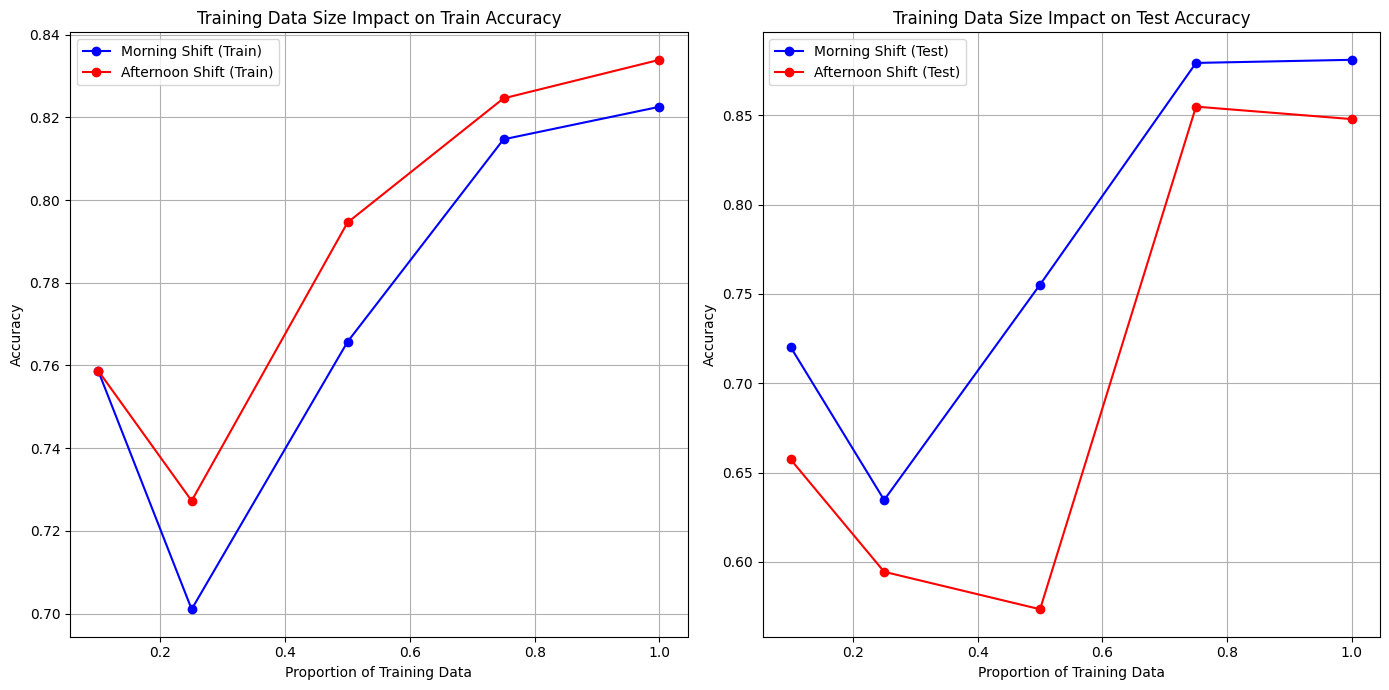

Training Size: 0.10
  Train Accuracy (Morning Shift): 0.7588
  Train Accuracy (Afternoon Shift): 0.7588
  Test Accuracy (Morning Shift): 0.7203
  Test Accuracy (Afternoon Shift): 0.6573

Training Size: 0.25
  Train Accuracy (Morning Shift): 0.7010
  Train Accuracy (Afternoon Shift): 0.7273
  Test Accuracy (Morning Shift): 0.6346
  Test Accuracy (Afternoon Shift): 0.5944

Training Size: 0.50
  Train Accuracy (Morning Shift): 0.7657
  Train Accuracy (Afternoon Shift): 0.7946
  Test Accuracy (Morning Shift): 0.7552
  Test Accuracy (Afternoon Shift): 0.5734

Training Size: 0.75
  Train Accuracy (Morning Shift): 0.8147
  Train Accuracy (Afternoon Shift): 0.8246
  Test Accuracy (Morning Shift): 0.8794
  Test Accuracy (Afternoon Shift): 0.8549

Training Size: 1.00
  Train Accuracy (Morning Shift): 0.8226
  Train Accuracy (Afternoon Shift): 0.8339
  Test Accuracy (Morning Shift): 0.8811
  Test Accuracy (Afternoon Shift): 0.8479



In [ ]:
# Define training data sizes to experiment with
training_sizes = [0.1, 0.25, 0.5, 0.75, 1.0]

# Variables to store results
train_accuracies_morning = []
train_accuracies_afternoon = []
test_accuracies_morning = []
test_accuracies_afternoon = []

for size in training_sizes:
    # Determine the split index based on size
    split_index = int(size * len(X_train_resampled))

    # Split the training data into subsets of different sizes
    X_train_sub = X_train_resampled[:split_index]
    y_train_sub = y_train_resampled[:split_index]

    # Apply PCA with the best number of components found previously
    pca = PCA(n_components=best_n_components)
    X_train_pca = pca.fit_transform(X_train_sub)
    X_test_pca = pca.transform(X_test_scaled)


    multioutput_best_mlp_model_tds = MultiOutputClassifier(best_mlp_model)
    multioutput_best_mlp_model_tds.fit(X_train_pca, y_train_sub)

    # Evaluate on the training subset
    y_pred_train, train_accuracies = evaluate_model(multioutput_best_mlp_model_tds, X_train_pca, y_train_sub)

    # Evaluate on the test set
    y_pred_test, test_accuracies = evaluate_model(multioutput_best_mlp_model_tds, X_test_pca, y_test)

    # Store accuracies for each output separately
    train_accuracies_morning.append(train_accuracies[0])
    train_accuracies_afternoon.append(train_accuracies[1])
    test_accuracies_morning.append(test_accuracies[0])
    test_accuracies_afternoon.append(test_accuracies[1])

# Plot the results
plt.figure(figsize=(14, 7))

# Training accuracies
plt.subplot(1, 2, 1)
plt.plot(training_sizes, train_accuracies_morning, marker='o', linestyle='-', color='b', label='Morning Shift (Train)')
plt.plot(training_sizes, train_accuracies_afternoon, marker='o', linestyle='-', color='r', label='Afternoon Shift (Train)')
plt.title('Training Data Size Impact on Train Accuracy')
plt.xlabel('Proportion of Training Data')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Test accuracies
plt.subplot(1, 2, 2)
plt.plot(training_sizes, test_accuracies_morning, marker='o', linestyle='-', color='b', label='Morning Shift (Test)')
plt.plot(training_sizes, test_accuracies_afternoon, marker='o', linestyle='-', color='r', label='Afternoon Shift (Test)')
plt.title('Training Data Size Impact on Test Accuracy')
plt.xlabel('Proportion of Training Data')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Print results
for size, train_morning, train_afternoon, test_morning, test_afternoon in zip(training_sizes, train_accuracies_morning, train_accuracies_afternoon, test_accuracies_morning, test_accuracies_afternoon):
    print(f"Training Size: {size:.2f}")
    print(f"  Train Accuracy (Morning Shift): {train_morning:.4f}")
    print(f"  Train Accuracy (Afternoon Shift): {train_afternoon:.4f}")
    print(f"  Test Accuracy (Morning Shift): {test_morning:.4f}")
    print(f"  Test Accuracy (Afternoon Shift): {test_afternoon:.4f}\n")
